In [1]:
# Make 'src/' importable from anywhere in the repo
import sys, os
from pathlib import Path

ROOT = Path.cwd()
# climb up until we find a folder that contains 'src'
while not (ROOT / "src").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

# sanity check
assert (ROOT / "src" / "__init__.py").exists(), f"'src/__init__.py' not found at {ROOT}/src"
print("Added to sys.path:", ROOT)

Added to sys.path: C:\Users\hirshikesh\Desktop\lct-corr-replication


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from src.FisherBaselines import (
    fisher_z, two_group_z_stat, vectorize_upper,
    pvals_from_Z, bh_threshold, by_threshold
)
from src.Evaluate import empirical_corr

In [3]:
# Tiny Toy Data for testing
rng = np.random.default_rng(0)
p, n1, n2 = 10, 40, 40

# Group 1: standard normal, independent
X = rng.normal(size=(n1, p))
# Group 2: inject a small block correlation among first 4 variables
Y = rng.normal(size=(n2, p))
Y[:, :4] = 0.7*Y[:, :4] + 0.3*rng.normal(size=(n2, 4))  # mild corr

R1 = empirical_corr(X)
R2 = empirical_corr(Y)

Z = two_group_z_stat(R1, R2, n1, n2)
pvals = pvals_from_Z(Z)
pvec = vectorize_upper(pvals)

alpha = 0.05
rej_bh = bh_threshold(pvec, alpha)
rej_by = by_threshold(pvec, alpha)

rej_bh.sum(), rej_by.sum()

(np.int64(0), np.int64(0))

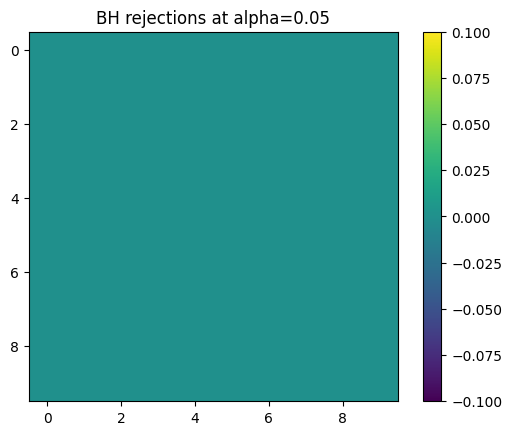

In [4]:
# Quick Heatmap of rejections
iu, ju = np.triu_indices(p, 1)
M = np.zeros((p,p), dtype=int)
M[iu, ju] = rej_bh.astype(int)
M = M + M.T
plt.imshow(M, interpolation="nearest")
plt.title(f"BH rejections at alpha={alpha}")
plt.colorbar()
plt.show()

In [5]:
def main():
    rng = np.random.default_rng(1)
    p, n1, n2 = 30, 60, 60
    X = rng.normal(size=(n1, p))
    Y = rng.normal(size=(n2, p))
    # inject corr among variables 0..5 in Y
    Y[:, :6] = 0.6*Y[:, :6] + 0.4*rng.normal(size=(n2, 6))

    R1 = empirical_corr(X)
    R2 = empirical_corr(Y)
    Z = two_group_z_stat(R1, R2, n1, n2)
    p = Z.shape[0]
    iu, ju = np.triu_indices(p, 1)
    pvals = pvals_from_Z(Z)[iu, ju]

    for alpha in (0.05, 0.1):
        bh = bh_threshold(pvals, alpha).sum()
        by = by_threshold(pvals, alpha).sum()
        print(f"alpha={alpha:.2f} → BH: {bh} edges, BY: {by} edges")

In [6]:
if __name__ == "__main__":
    main()

alpha=0.05 → BH: 0 edges, BY: 0 edges
alpha=0.10 → BH: 2 edges, BY: 0 edges
